<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Введение в рекомендательные системы</center></h2>

In [5]:
!pip install numba

    100% |████████████████████████████████| 1.8MB 349kB/s ta 0:00:01
    100% |████████████████████████████████| 13.3MB 64kB/s  eta 0:00:01


In [6]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Подготовка данных

1. Скачайте [данные](https://cloud.mail.ru/public/CSjR/mPctRVc2u) о рейтингах и фильмах
2. Загрузите рейтинги (user_ratedmovies.dat) и описание фильмов (movies.dat)
3. С помощью LabelEncoder перекодируйте идентификаторы фильмов и юзеров в обоих датафреймах


In [7]:
df_ratings = pd.read_csv('data/user_ratedmovies.dat', sep='\t')
df_movies = pd.read_csv('data/movies.dat', sep='\t', encoding='latin1')

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
mov_enc = LabelEncoder()
user_enc = LabelEncoder()

In [10]:
mov_enc.fit(df_ratings.movieID.values)
user_enc.fit(df_ratings.userID.values)

LabelEncoder()

In [11]:
idx = df_movies.loc[:, 'id'].isin(df_ratings.movieID)
df_movies = df_movies.loc[idx, :]

In [12]:
df_ratings.loc[:, 'movieID'] = mov_enc.transform(
    df_ratings.loc[:, 'movieID'])
df_ratings.loc[:, 'userID'] = user_enc.transform(
    df_ratings.loc[:, 'userID'])

In [13]:
df_movies.loc[:, 'id'] = mov_enc.transform(
    df_movies.loc[:, 'id'])


In [14]:
df_ratings.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,0,2,1.0,29,10,2006,23,17,16
1,0,31,4.5,29,10,2006,23,23,44
2,0,105,4.0,29,10,2006,23,30,8
3,0,151,2.0,29,10,2006,23,16,52
4,0,154,4.0,29,10,2006,23,29,30


In [15]:
df_ratings.userID.nunique()

2113

In [16]:
df_ratings.userID.describe()
df_ratings.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,0,2,1.0,29,10,2006,23,17,16
1,0,31,4.5,29,10,2006,23,23,44
2,0,105,4.0,29,10,2006,23,30,8
3,0,151,2.0,29,10,2006,23,16,52
4,0,154,4.0,29,10,2006,23,29,30


# Сжатое представление фильмов

1. С помощью from scipy.sparse.coo_matrix составьте разреженную матрицу рейтингов
2. С помощью scipy.sparse.linalg.svds получите латентное описание фильмов и пользователей
3. Для каждого фильма найдите 10 ближайших соседей в этих признаках по косинусной мере

In [17]:
from scipy.sparse import coo_matrix

In [18]:
n_users = df_ratings.userID.nunique()
n_movies = df_ratings.movieID.nunique()

In [19]:
R = coo_matrix((df_ratings.rating.values, 
                (df_ratings.userID.values, 
                 df_ratings.movieID.values)), 
              shape=(n_users, n_movies), dtype=np.float)

In [20]:
R.nnz

855598

In [21]:
from scipy.sparse.linalg import svds

In [22]:
U, S, Vt = svds(R, k=6)

In [23]:
S

array([  348.46928961,   388.72357327,   395.35976356,   493.67832495,
         581.54459324,  1861.07048692])

In [24]:
U.shape

(2113, 6)

In [25]:
Vt.shape

(6, 10109)

In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(Vt.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [28]:
d, nn_idx = nn.kneighbors(Vt.T, n_neighbors=10)

In [29]:
nn_idx

array([[    0,  4550,  7871, ...,  2671,  1144,   565],
       [    1,  3662,  1337, ...,  7570,   144,  4874],
       [    2,  5473,   266, ...,  4960,  1259,  1937],
       ..., 
       [10106,   899,  1488, ...,  3184,     8,   724],
       [10107, 10083,  4041, ...,  3922,  9792,  8266],
       [10108,   824,  1171, ...,  5756,  7048,  8067]])

In [30]:
titles = df_movies.loc[:, 'title'].values

In [31]:
df_movies_nn = pd.DataFrame(titles[nn_idx])

In [32]:
idx = df_movies_nn.iloc[:,0].str.contains('Harry')

In [108]:
idx.sum()

16

# User-based CF

* Разбейте данные на обучение и контроль в пропорции 80/20
* Реализуйте функцию расчета попарных схожестей между пользователями
* Реализуйте метод расчета рекомендаций на основе $K$ наиболее похожих пользователей. Постройте график зафисимости ошибки MAE от $K$ (5-25)
* Выполните нормализацию рейтингов с помощью вычитания средней оценки $\bar{R}_u$ каждого из пользователей и повторите предыдущий 2 шага. В этом случае предсказание выполняется следующим образом
$$ \hat{R}_{ui} = \bar{R}_u + \frac{\sum_{v \in N(u)} s_{uv} (R_{vi} - \bar{R}_v)}{\sum_{v \in N(u)}| s_{uv}|} $$
* Перейдите к Item-Based подходу и повторите предыдущие шаги

In [33]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import correlation
from sklearn.metrics import pairwise_distances

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
df_train, df_test = train_test_split(df_ratings,
                                    test_size=0.2,
                                    train_size=0.8)

In [36]:
R_train = coo_matrix((df_train.rating.values, (df_train.userID.values,
                                              df_train.movieID.values)), shape=(n_users, n_movies))

In [117]:
R_train = R_train.toarray()

In [118]:
def similarity(u, v):
    idx = (u != 0) & (v != 0)
    if any(idx):
        return -cosine(u[idx], v[idx]) + 2
    else:
        return 0;


In [119]:
D = pdist(R_train, metric=similarity)

In [120]:
D = squareform(D)

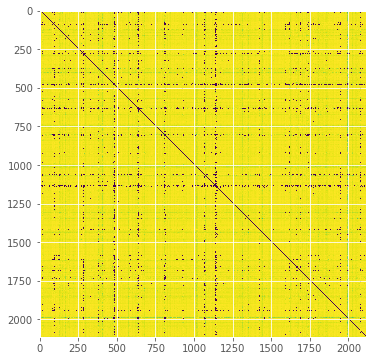

In [121]:
plt.imshow(D)

In [122]:
predicted_ratings = []